이번 과제에서 저는 vit모델을 허깅페이스에서 가지고와서 전이학습을 하여 사용해 보기로 하였습니다 .

이미지 전처리 이미지는 수동으로 구분 하였습니다. 이미지상에는 문제가 있는 사람들이 많거나 ,그림, 또는 거의 보이지 않는 꽃등 실질적으로 학습에 저해되는 요소들이 많아 보여서 일일이 제거하였으며 민들레꽃의 경우 절반이상의 비중을 차지하는 민들레씨 부분이 있기에 두가지의 폴더를 나누어 라벨링은 똑같이 나오게 하되 학습은 따로 하여 적용 시켰습니다. 분류후에는 민들레를 제외한 각각의 꽃들이 500장 이상씩 분류되었고 민들레의경우 꽃이 200장 씨앗부분이 500장이 넘어가는 숫자를 구성하였습니다.


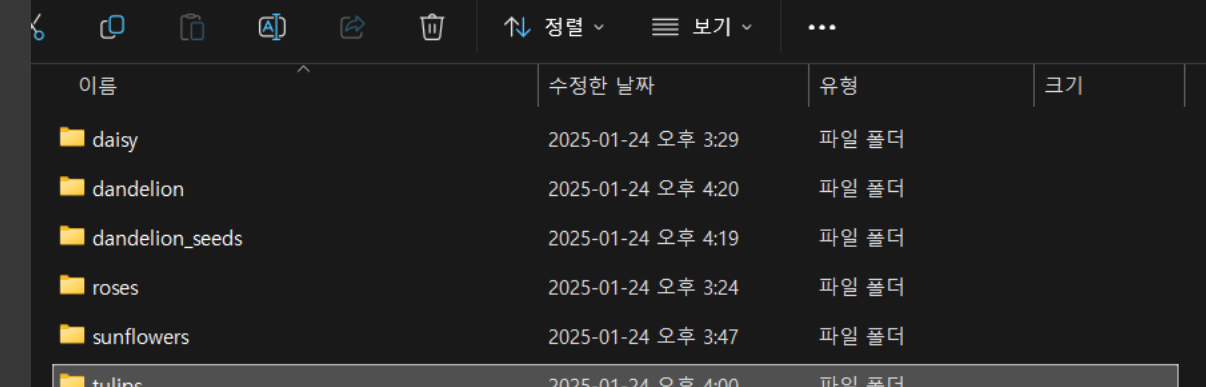

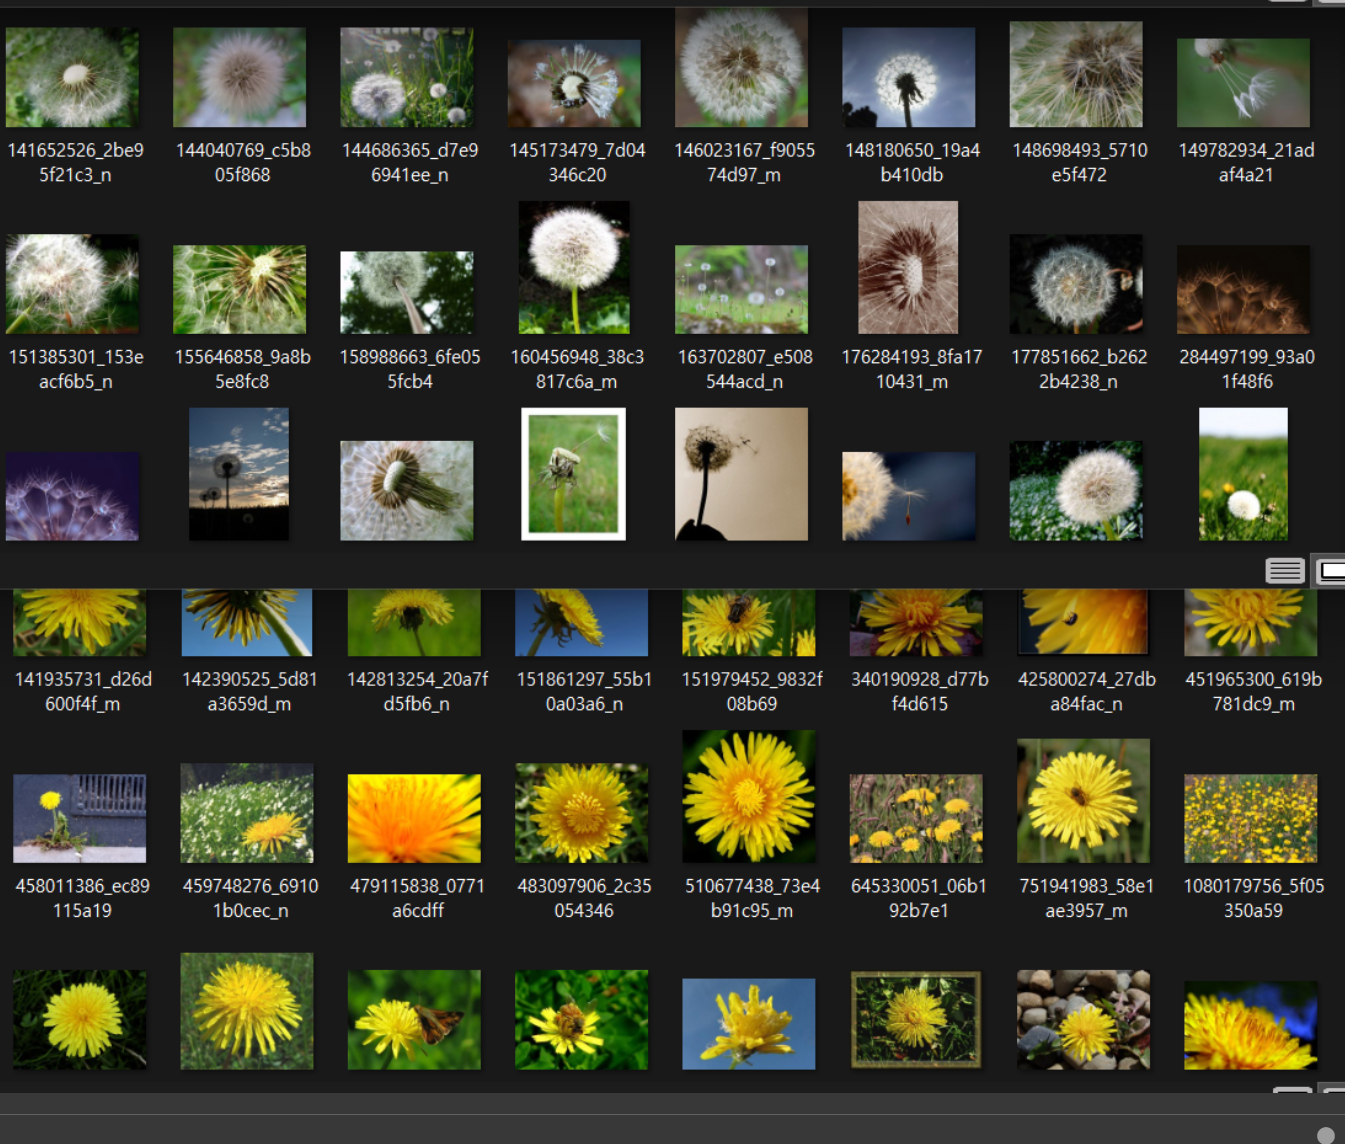

전처리한 데이터를 가지고 어떤 모델을 가지고 전이학습을 할지 골랐고 허깅페이스에서 102 클래스의 꽃을 가지고 VIT 모델로 학습킨 프리트레인 모데일이 있기에 이것을 사용하여 적용해보기로 결정하였습니다.
밑에는 전이 학습시 사용한 코드입니다.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from google.colab import drive

# ✅ Google Drive 마운트
drive.mount('/content/drive')

# ✅ 데이터 경로 (Google Drive 경로로 변경)
DATASET_PATH = "/content/drive/My Drive/flower_preprocessing"

# ✅ 사전 훈련된 ViT 모델 (Flowers-102 데이터셋 기반)
model_name = "KietZer0/ViT_Flower102_2"
processor = ViTImageProcessor.from_pretrained(model_name)  # FeatureExtractor 대신 ImageProcessor 사용
model = ViTForImageClassification.from_pretrained(
    model_name, num_labels=5, ignore_mismatched_sizes=True
)

# ✅ 분류기 레이어를 새롭게 정의
model.classifier = nn.Linear(model.config.hidden_size, 5)  # 5개 클래스에 맞게 수정

# ✅ 클래스 라벨 정의 (dandelion_seeds → dandelion 통합)
class_mapping = {
    "daisy": "daisy",
    "dandelion": "dandelion",
    "dandelion_seeds": "dandelion",
    "roses": "roses",
    "sunflowers": "sunflowers",
    "tulips": "tulips",
}
updated_class_names = sorted(set(class_mapping.values()))

# ✅ 이미지 전처리 (ViT에 맞게 적용)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# ✅ 맞춤형 데이터셋 로더
class FlowerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                label = updated_class_names.index(class_mapping.get(folder, folder))  # 클래스 매핑 적용
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    self.data.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ✅ 데이터셋 로드
batch_size = 32
dataset = FlowerDataset(DATASET_PATH, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ✅ 모델 설정 (GPU 사용 가능하면 GPU로 이동)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# ✅ 학습 루프
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits  # ViT 모델에서 로짓 값 가져오기
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# ✅ 모델 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# ✅ 모델 저장 (Google Drive에 저장)
save_path = "/content/drive/My Drive/vit_flower102_finetuned.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at KietZer0/ViT_Flower102_2 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([150, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Loss: 0.4653
Epoch [2/5], Loss: 0.0614
Epoch [3/5], Loss: 0.0214
Epoch [4/5], Loss: 0.0109
Epoch [5/5], Loss: 0.0072
Test Accuracy: 100.00%
Model saved at /content/drive/My Drive/vit_flower102_finetuned.pth


이후 학습된 모델을 가지고 인터넷에있는 다른 테스트셋들을 각 종류별 10장씩 모아서 테스트 해봤습니다.

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import io

# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 모델 경로
model_path = r"C:\Users\dkdle\Desktop\flower_test\vit_flower102_finetuned.pth"
model_name = "KietZer0/ViT_Flower102_2"

# ✅ 모델 불러오기
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name, num_labels=5, ignore_mismatched_sizes=True
)
model.classifier = nn.Linear(model.config.hidden_size, 5)  # 클래스 개수 수정

# ✅ 가중치 로드 (strict=False 추가)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=False)  # 크기 불일치 해결
model.to(device)
model.eval()

# ✅ 클래스 라벨 정의
class_mapping = {
    "daisy": "daisy",
    "dandelion": "dandelion",
    "roses": "roses",
    "sunflowers": "sunflowers",
    "tulips": "tulips",
}
updated_class_names = sorted(set(class_mapping.values()))  # ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# ✅ 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# ✅ 테스트 데이터 경로
test_dir = r"C:\Users\dkdle\Desktop\flower_test"

# ✅ 이미지 확장자 필터링 추가
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# ✅ 결과 저장
correct = 0
total = 0
class_correct = {cls: 0 for cls in updated_class_names}
class_total = {cls: 0 for cls in updated_class_names}

# ✅ 폴더별 이미지 테스트 실행
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):  # 폴더가 아닌 경우 무시
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # ✅ 이미지 파일만 로드
        if not img_path.lower().endswith(valid_extensions):
            continue  # .jpg, .png 같은 이미지 확장자만 허용

        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가

        with torch.no_grad():
            outputs = model(image).logits
            _, predicted = torch.max(outputs, 1)
            predicted_class = updated_class_names[predicted.item()]  # 예측된 클래스

        # ✅ 정답 여부 확인
        if predicted_class == class_name:
            correct += 1
            class_correct[class_name] += 1

        total += 1
        class_total[class_name] += 1

# ✅ 최종 정확도 출력
print(f"전체 테스트 데이터 정확도: {100 * correct / total:.2f}%")

# ✅ 클래스별 정확도 출력
for cls in updated_class_names:
    if class_total[cls] > 0:
        accuracy = 100 * class_correct[cls] / class_total[cls]
        print(f"{cls} 정확도: {accuracy:.2f}% ({class_correct[cls]}/{class_total[cls]})")


실행결과는 밑에다 사진으로 첨부하겠습니다.
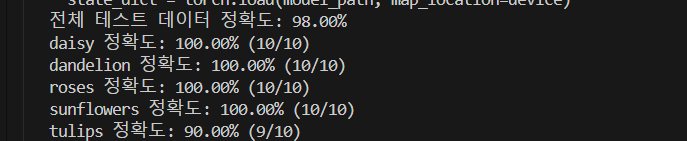

이후 학습이 어느정도 잘 되어있기에 플러터에 FASTAPI로 돌아가는것을 확인 하였습니다.

여기서 문제점은 허깅페이스에서 모델을 불러와서 사용시 저장된 부분은 파인튜닝된 부분만 저장되어있기 때문에 모델을 다시불러와서 써야하는데 파인튜닝의 출력은 5개클래스로 했던 반면 불러오게된 모델은 102클래스로 다시 되돌아 가서 불러지기 때문에 이러한 부분에서 오류가 많이 났어고 코드상 5개만 적용되도록 구성하는 부분이 필요 하였습니다.

In [ ]:
#fAST API 구현 부분
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastapi import FastAPI, UploadFile, File
from fastapi.middleware.cors import CORSMiddleware
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import io

app = FastAPI()

# ✅ CORS 설정 (Flutter에서 접근 가능하도록 허용)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # 특정 도메인만 허용할 경우 "http://localhost:8000" 등으로 변경
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# ✅ 모델 및 프로세서 설정
MODEL_PATH = r"C:\Users\dkdle\Desktop\flower_test\vit_flower102_finetuned.pth"
MODEL_NAME = "KietZer0/ViT_Flower102_2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME, num_labels=5, ignore_mismatched_sizes=True
)

# ✅ 커스텀 분류기 설정
model.classifier = nn.Linear(model.config.hidden_size, 5)

# ✅ 가중치 불러오기 (strict=False 사용하여 크기 불일치 문제 해결)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# ✅ 클래스 라벨 정의
class_labels = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

# ✅ 이미지 예측 함수
def predict_image(image: Image.Image):
    try:
        image = processor(image, return_tensors="pt")["pixel_values"]
        image = image.to(device)

        with torch.no_grad():
            outputs = model(image).logits
            probabilities = F.softmax(outputs, dim=1)  # ✅ 신뢰도(Confidence) 값 계산
            confidence, predicted_idx = torch.max(probabilities, 1)

        predicted_class = class_labels[predicted_idx.item()]
        return {"predicted_class": predicted_class, "confidence": confidence.item()}

    except Exception as e:
        return {"error": str(e)}

# ✅ FastAPI 엔드포인트
@app.post("/predict")  # ✅ URL 변경 (/predict/ → /predict)
async def predict(file: UploadFile = File(...)):
    try:
        image = Image.open(io.BytesIO(await file.read())).convert("RGB")
        result = predict_image(image)
        return result
    except Exception as e:
        return {"error": str(e)}


플러터는 단순한 화면에 구현부분만 영상으로 찍기위해 구성하였습니다.

In [ ]:
import 'dart:convert';
import 'dart:io';
import 'package:flutter/material.dart';
import 'package:http/http.dart' as http;
import 'package:image_picker/image_picker.dart';

void main() => runApp(MyApp());

class MyApp extends StatelessWidget {
  @override
  Widget build(BuildContext context) {
    return MaterialApp(
      home: ImageUploadPage(),
    );
  }
}

class ImageUploadPage extends StatefulWidget {
  @override
  _ImageUploadPageState createState() => _ImageUploadPageState();
}

class _ImageUploadPageState extends State<ImageUploadPage> {
  File? _image;
  String? _prediction;
  double? _confidence; // ✅ 신뢰도 값 추가
  final ImagePicker _picker = ImagePicker();

  // ✅ 이미지 선택 함수
  Future<void> _pickImage() async {
    final pickedFile = await _picker.pickImage(source: ImageSource.gallery);

    if (pickedFile != null) {
      setState(() {
        _image = File(pickedFile.path);
        _prediction = null;
        _confidence = null;
      });
    }
  }

  // ✅ 이미지 업로드 및 예측 함수
  Future<void> _uploadImage() async {
    if (_image == null) return;

    final uri = Uri.parse("http://10.0.2.2:8000/predict");  // ✅ 로컬 서버 접근 변경
    final request = http.MultipartRequest("POST", uri);
    request.files.add(await http.MultipartFile.fromPath("file", _image!.path));

    try {
      final response = await request.send();
      if (response.statusCode == 200) {
        final responseData = await http.Response.fromStream(response);
        final result = jsonDecode(responseData.body);

        print("Server response: $result");  // ✅ Debug log

        setState(() {
          _prediction = result['predicted_class'].toString();
          _confidence = result['confidence'];
        });
      } else {
        setState(() {
          _prediction = "Error: ${response.reasonPhrase}";
          _confidence = null;
        });
      }
    } catch (e) {
      setState(() {
        _prediction = "Error: $e";
        _confidence = null;
      });
    }
  }

  @override
  Widget build(BuildContext context) {
    return Scaffold(
      appBar: AppBar(title: Text("Image Prediction")),
      body: Padding(
        padding: const EdgeInsets.all(16.0),
        child: Column(
          children: [
            if (_image != null) Image.file(_image!, height: 200),
            const SizedBox(height: 20),
            if (_prediction != null)
              Text(
                _confidence != null
                    ? "Prediction: $_prediction\nConfidence: ${(_confidence! * 100).toStringAsFixed(2)}%"
                    : "Waiting for prediction...",
                style: TextStyle(fontSize: 16),
                textAlign: TextAlign.center,
              ),
            const SizedBox(height: 20),
            ElevatedButton(onPressed: _pickImage, child: Text("Pick Image")),
            const SizedBox(height: 10),
            ElevatedButton(onPressed: _uploadImage, child: Text("Upload and Predict")),
          ],
        ),
      ),
    );
  }
}
